In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.circuit.library import HGate
from scipy.optimize import minimize
import numpy as np
from qiskit.quantum_info import Statevector


import qc_utils as qcu
from ansatz import HE_ansatz,fixed_ansatz

In [2]:
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer.primitives import EstimatorV2 as Estimator

In [3]:
def calculate_psi_norm(qc_ansatz, A_LCU):
    """ 
    This function evaluates the norm of the solution |psi>. |psi> = A|\tilde{x}> = AV|0>. 
    <psi|psi> = sum_{lm} a_m* a_l beta_{lm}
    beta_{lm} = <0|V^T A_{m}^T A_{l} V |0> 
    """

    operators = []
    for op_i in A_LCU:
        for op_j in A_LCU:
            op = op_j.adjoint() @ op_i
            operators.append(op)
    

    backend = AerSimulator()
    pass_manager = generate_preset_pass_manager(backend=backend ,optimization_level=0)
    qc_ansatz_transpiled = pass_manager.run(qc_ansatz)
    operators_transpiled_list = [op.apply_layout(qc_ansatz_transpiled.layout) for op in operators] 

    ops = list(op.paulis for op in operators_transpiled_list)
    ops_coeff = list(op.coeffs for op in operators_transpiled_list)

    estimator = Estimator()
    job = estimator.run([(qc_ansatz_transpiled, ops)])

    result = job.result()[0]
    values = result.data.evs

    inner_product = 0
    for i in range(len(ops)):
        inner_product += ops_coeff[i]*values[i]

    return inner_product

def calculate_inner_product_b_psi(qc_ansatz, B_gate, A_LCU):
    """
    This function is used to evaluate <b|psi> = <0|B^T A V |0> = sum_{ijk} b_i* a_j v_k B_i^T A_j V_k . 
    A = sum_{j} a_j A_j.
    B = sum_{i} b_i B_i.
    V = sum_{k} v_k V_k.
    """

    V_LCU = qcu.get_LCU(qc_ansatz)
    b_LCU = qcu.get_LCU(Operator(B_gate))

    operators = []
    for op_i in b_LCU:
        for op_j in A_LCU:
            for op_k in V_LCU:
                op = op_i.adjoint() @ op_j @ op_k
                operators.append(op)
    
    qc = QuantumCircuit(qc_ansatz.num_qubits)

    backend = AerSimulator()
    pass_manager = generate_preset_pass_manager(backend=backend ,optimization_level=0)
    qc_transpiled = pass_manager.run(qc)
    operators_transpiled_list = [op.apply_layout(qc_transpiled.layout) for op in operators] 

    ops = list(op.paulis for op in operators_transpiled_list)
    ops_coeff = list(op.coeffs for op in operators_transpiled_list)

    estimator = Estimator()
    job = estimator.run([(qc_transpiled, ops)])

    result = job.result()[0]
    values = result.data.evs

    inner_product = 0
    for i in range(len(ops)):
        inner_product += ops_coeff[i]*values[i]

    return inner_product

def calculate_inner_product_psi_b(qc_ansatz, B_gate, A_LCU):
    """
    This function is used to evaluate <psi|b> = <0|V^T A^T B |0> = sum_{ijk} b_i a_j* v_k* V_k^T A_j^T B_i . 
    A = sum_{j} a_j A_j.
    B = sum_{i} b_i B_i.
    V = sum_{k} v_k V_k.
    """

    V_LCU = qcu.get_LCU(qc_ansatz)
    b_LCU = qcu.get_LCU(Operator(B_gate))

    operators = []
    for op_i in b_LCU:
        for op_j in A_LCU:
            for op_k in V_LCU:
                op = op_k.adjoint() @ op_j.adjoint() @ op_i
                operators.append(op)
    
    qc = QuantumCircuit(qc_ansatz.num_qubits)

    backend = AerSimulator()
    pass_manager = generate_preset_pass_manager(backend=backend ,optimization_level=0)
    qc_transpiled = pass_manager.run(qc)
    operators_transpiled_list = [op.apply_layout(qc_transpiled.layout) for op in operators] 

    ops = list(op.paulis for op in operators_transpiled_list)
    ops_coeff = list(op.coeffs for op in operators_transpiled_list)

    estimator = Estimator()
    job = estimator.run([(qc_transpiled, ops)])

    result = job.result()[0]
    values = result.data.evs

    inner_product = 0
    for i in range(len(ops)):
        inner_product += ops_coeff[i]*values[i]

    return inner_product

In [4]:
global_cost_history = []
def calculate_global_cost(params, ansatz, n, d, A_LCU, B_gate):
    """
    This function evaluates the global cost Hamiltonian.
    C_{G} = 1 - \frac{|<b|psi>|^2}{<psi|psi>}
    """
    qc = ansatz(n, d, params)
    den = calculate_psi_norm(qc_ansatz=qc, A_LCU=A_LCU)
    
    b_psi = calculate_inner_product_b_psi(qc_ansatz=qc, B_gate=B_gate, A_LCU=A_LCU)
    psi_b = calculate_inner_product_psi_b(qc_ansatz=qc, B_gate=B_gate, A_LCU=A_LCU)
    num = b_psi*psi_b

    cost = np.squeeze(1  - (num/den)).real
    global_cost_history.append(cost)
    print(cost)

    return cost

In [5]:
# A = 0.55*SparsePauliOp('III') + 0.45*SparsePauliOp('IIZ')
A = SparsePauliOp('III') + 0.2*SparsePauliOp('XZI') + 0.2*SparsePauliOp('XII')
B = Operator(HGate()).expand(HGate()).expand(HGate())
B_gate = qcu.make_gate(B,label='B')

A_LCU = qcu.get_LCU(A)
A_LCU

SparsePauliOp(['III', 'XII', 'XZI'],
              coeffs=[1. +0.j, 0.2+0.j, 0.2+0.j])

In [6]:
# params = [i for i in range(9)]
params = [0 for i in range(6)]
n = 3
d = 2
qc_ansatz = fixed_ansatz(n,d,params)
qc_ansatz.draw()

┌───────┐   ┌───────┐               
q_0: ┤ Ry(0) ├─■─┤ Ry(0) ├──────────■────
     ├───────┤ │ └───────┘┌───────┐ │    
q_1: ┤ Ry(0) ├─■─────■────┤ Ry(0) ├─■──■─
     ├───────┤       │    ├───────┤    │ 
q_2: ┤ Ry(0) ├───────■────┤ Ry(0) ├────■─
     └───────┘            └───────┘

In [7]:
sol_global = minimize(
    lambda params: calculate_global_cost(params, fixed_ansatz, n, d, A_LCU, B_gate),
    params,
    method="COBYLA",
    options={'maxiter':50}
    )

0.7887931034482759
0.6110686282086772
0.40213229632090386
0.24673114369251936
0.3354269222654569
0.33594246956640417
0.3519239074915893
0.05513378688366899
0.24663417177587876
0.25475778529827553
0.06589976516770979
0.06756988940583963
0.02433682514297464
0.002349655308001908
0.07745197849669172
0.020953982446482278
0.0434829195487173
0.00761876447821197
0.005476285753432841
0.005032869485606661
0.007702051127506326
0.0007561179699050458
0.002442943182715873
0.001165876926193521
0.0014104050040922855
0.0007170056167103978
0.0017348543817591322
0.000687373476033426
0.0013239680964443057
0.00019301781197178514
0.0007234608834948419
0.00023355419210002726
0.00033557737110168073
0.00022334684029146068
0.00017155399397394966
0.0001964572077852722
0.00012128899855201603
0.00012013685366796256
0.0001287754620283854
4.973185680690051e-05
8.04018099237469e-05
7.864834375481689e-05
6.472507962684837e-05
5.5113508389492694e-05
6.546185060163356e-05
4.5459195395447516e-05
4.3879223801890355e-05
4.

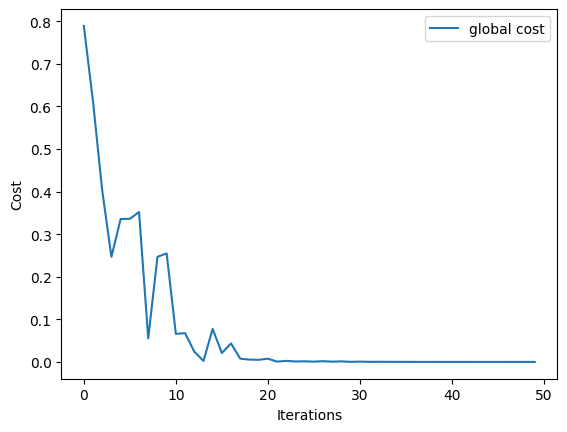

In [8]:
import matplotlib.pyplot as plt

plt.plot(global_cost_history, label = "global cost")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.legend()
plt.show()

In [9]:
qc_sol_global = fixed_ansatz(n,d,sol_global.x)

In [10]:
sv_qc = Statevector(qc_sol_global)

In [11]:
b = B.to_matrix()@np.array(list([1] + [0 for i in range(2**n-1)]))
x_exact = np.linalg.inv(A.to_matrix()) @ b
sv_x_exact = Statevector(x_exact)
sv_x_exact = sv_x_exact/np.sqrt(sv_x_exact.inner(sv_x_exact))

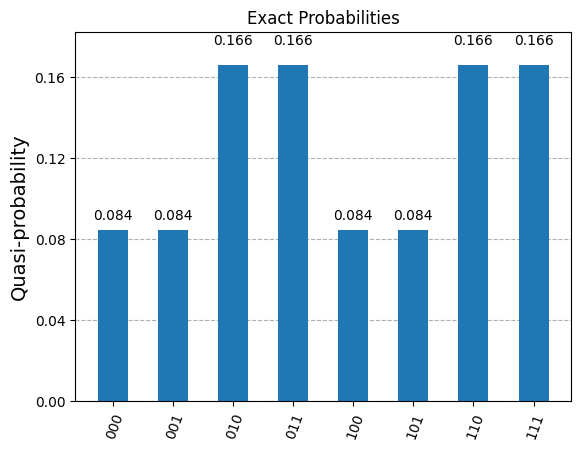

In [12]:
from qiskit.visualization import plot_histogram

plot_histogram(sv_x_exact.probabilities_dict(),title='Exact Probabilities')

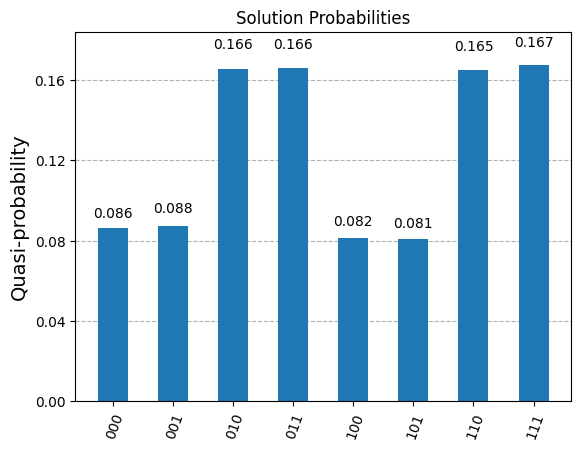

In [13]:
plot_histogram(sv_qc.probabilities_dict(),title='Solution Probabilities')